# Assignment 1b Notebook
This notebook will build off of progress made in Assignment 1a to guide you through the implementation of a basic evolutionary algorithm (EA). As such, you should copy the files `linear_genotype.py` and `1a_notebook.ipynb` from the previous assignment repo to the repo for this assignment. Be careful not to overwrite the other files in the repo though, as we may have made modifications to the fitness function to make evolution more interesting. Please complete this notebook and read *all* text cells.

### Note:
We have modified the problem instance in order to result in more interesting bridge generation. Since you will be comparing against random search and changing the problem instance invalidates comparison with your data from Assignment 1a, we have provided you with a file of random search data in `/data/uniformRandomResults.txt`.

As usual, start by evaluating the next cell to configure the notebook. If this is your first time using a Jupyter notebook, you can press `shift+enter` to execute the Python code in a selected cell.

In [ ]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print('The first cell has been executed!')

## Evolutionary Algorithm
The following diagram depicts the flow of a standard EA:
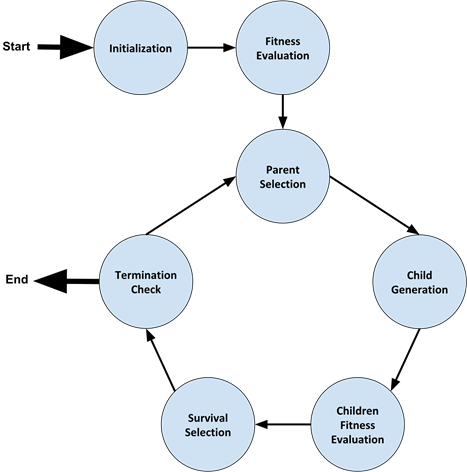

There are many different ways to implement an EA but in this class we're providing you with a partially-complete framework that demonstrates a modular way to structure code and maximize code re-use throughout the assignments. This means you can gain experience with a code base like what we use in research *and* it means we can just give you code for some of the more mundane and unimportant parts of an EA. Namely, we can give you a configuration parser we use in research.

### The snake_eyes Configuration Parser
The [snake_eyes configuration parser](https://github.com/DeaconSeals/snake_eyes) was developed for research in our lab and is specifically designed for frameworks like the one you'll be working with. The GitHub repo has more general-purpose documentation for using this configuration parser if you're interested in reading more, but the short version is that it takes a configuration file in an ini format and converts it into a nested dictionary containing the sections and key-value pairs from your configuration file. That's only somewhat different than the [built-in Python configuration parser](https://docs.python.org/3/library/configparser.html) (which [snake_eyes](https://github.com/DeaconSeals/snake_eyes) is built on top of). The most valuable part of [snake_eyes](https://github.com/DeaconSeals/snake_eyes) is that it performs interpolation to type and execute parameter values as code during parsing. This lets us do things like reference constants, functions, and even pass arguments for those functions all from within the configuration file!

This approach might seem a bit quirky, but it can drastically reduce the amount of code refactoring required to add new functionality and we're giving you an example configuration file to show off how to use it. The following cell will parse our example configuration file and retrieve parameters to use throughout the rest of the notebook:

In [ ]:
from selection import * # we'll fill this out later
from snake_eyes import read_config

config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())

print('These are the contents of the config file:')
for section in config:
    print(section)
    if config[section] == {}:
        print(config[section])
    else:
        for parameter in config[section]:
            print(f'\t{parameter} : {config[section][parameter]}')

del config # to prevent haphazard copypasta and global scope abuse

In order to make sure your code is ready for this assignment and works as intended, we'll carry out a brief (and not very thorough) test of your `LinearGenotype.random_initialization` implementation in the following cell. This also gives us an excuse to show how to make use of our config dictionary and Python's method for unpacking a dictionary into named keyword arguments for a function (`**kwargs`).

We'll use parameters from our configuration file to both test `random_initialization` and evaluate the fitness of the generated individual.

In [ ]:
from linear_genotype import LinearGenotype
from bridge_fitness import basic_simulation, plot_bridge

config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())
test_solution = LinearGenotype()
test_solution.random_initialization(**config['initialization_kwargs'])

length = config['initialization_kwargs']['length']
print(f'The randomInitialization function did something? {test_solution.gene is not None}')
print(f'Was the solution the right length? {len(test_solution.gene) == length}')

test_solution.fitness, test_solution.bridge = basic_simulation(test_solution.gene, **config['fitness_kwargs'])

print(f"The solution's fitness was {test_solution.fitness:,} and looks like the following:")
plot_bridge(test_solution.bridge)

del config, test_solution, length

### Initialization
Recall that the random search algorithm implemented in Assignment 1a is functionally equivalent to the initialization step performed at the beginning of an EA. While there are alternative initialization methods that seed the initial population with known-good solutions or even perform a preliminary search, the most common method is to initialize the population with randomly-generated solutions.

Those of you who have looked at the other member functions of the `LinearGenotype` class may have noticed the `initialization` class method. In later assignments (when using other genotypes) you'll have to write this function yourself but, due to the simplicity of initialization with a fixed-length binary string, we decided if would be more valuable to give you an example of an initialization function. The code for `LinearGenotype.initialization` is as follows:
```python
class LinearGenotype():
    ...
    @classmethod
	def initialization(cls, mu, *args, **kwargs):
		population = [cls() for _ in range(mu)]
		for i in range(len(population)):
			population[i].random_initialization(*args, **kwargs)
		return population
```


The following cell will use your `LinearGenotype.random_initialization` method to initialize an entire population as a list.

In [ ]:
config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())
example_population = LinearGenotype.initialization(10, **config['initialization_kwargs'])

print(f'Population size: {len(example_population)}')
print(f'Number of uninitialized individuals: {len([individual.gene for individual in example_population if individual.gene is None])}')
length = config['initialization_kwargs']['length']
print(f'Number of individuals with incorrect length: {len([individual.gene for individual in example_population if len(individual.gene) != length])}')

del config, example_population

### Fitness Evaluation
Now that you can initialize a population, implement the `basic_population_evaluation` function in `bridge_population_evaluation.py` to perform a fitness evaluation on all individuals in an input population using input fitness keyword arguments. Each individual should have `fitness` and `bridge` member variables assigned as demonstrated in the above cells.

We'll test your implementation in the next cell.

In [ ]:
from bridge_population_evaluation import basic_population_evaluation
import statistics

config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())
example_population = LinearGenotype.initialization(10, **config['initialization_kwargs'])

# calling your function to test things out
basic_population_evaluation(example_population, **config['fitness_kwargs'])

print(f'Individuals with unassigned fitness: {len([individual.fitness for individual in example_population if individual.fitness is None])}')
print(f'Number of fitness evaluations performed: {len([individual.fitness for individual in example_population if individual.fitness is not None])}')
print(f'Average fitness of population: {statistics.mean([individual.fitness for individual in example_population]):,}')
max_fitness = max([individual.fitness for individual in example_population])
print(f'Best fitness in population: {max_fitness:,}')
best_bridge = None
for individual in example_population:
    if individual.fitness == max_fitness:
        best_bridge = individual.bridge
        break

print(f'Found bridge of highest fitness individual? {best_bridge is not None}')
print('The bridge of the highest-fitness individual looks like the following:')
plot_bridge(best_bridge)

del config, example_population, max_fitness, best_bridge

### Parent Selection
After evaluating the initial population, the evolutionary cycle begins with parent selection. You will now implement the parent selection methods in the `selection.py` file. This file also contains survival selection functions that we will implement later. In general though, parent selection algorithms can select the same individual multiple times (i.e., an individual can reproduce multiple times in a given generation). There are multiple ways to select parents, but the two most common approaches are the following:
 * Select all parents at once to form a "parent pool"
 * Select parents as you generate children

Both techniques have scenarios where they make more or less sense to use, but which approach to use tends to be a matter of personal preference. In either approach, however, it's important to consider and minimize sampling error in your implementation. As a rule of thumb, avoid scenarios where a parent must win lotteries *after* being selected as a parent in order to actually reproduce. 

To accommodate both of the previously mentioned parent selection techniques, we provide a consistent interface for selection functions. Selection functions take as input a population and the number of individuals that should be selected with the appropriate selection algorithm. Algorithms like k-tournament also take as input the value `k` which denotes tournament size. To start off, implement `uniform_random_selection` in `selection.py` which should uniform randomly select from all individuals in the population (i.e, with equal probability). This algorithm is *with replacement* since each individual can be selected any number of times.

In [ ]:
config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())
example_population = LinearGenotype.initialization(10, **config['initialization_kwargs'])
basic_population_evaluation(example_population, **config['fitness_kwargs'])

num_parents = 20
parents = uniform_random_selection(example_population, num_parents)

print(f'The function did something? {parents is not None}')
print(f'The correct number of parents were selected? {len(parents)==num_parents}')

del config, example_population, num_parents, parents

Now implement `k_tournament_with_replacement` in `selection.py`. This algorithm samples `k` individuals from the population then selects the most fit as the parent, and repeats this process `num_parents` times. The individual tournaments are *without replacement* (i.e., the `k` individuals in any given tournament are all unique). However, the algorithm overall samples *with replacement*, meaning an individual can be selected multiple times (i.e., winning one tournament does not disqualify you from other tournaments). 

In [ ]:
config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())
example_population = LinearGenotype.initialization(10, **config['initialization_kwargs'])
basic_population_evaluation(example_population, **config['fitness_kwargs'])

num_parents = 20
parents = k_tournament_with_replacement(example_population, num_parents, k=2)

print(f'The function did something? {parents is not None}')
print(f'The correct number of parents were selected? {len(parents)==num_parents}')

del config, example_population, num_parents, parents

Finally, implement `fitness_proportionate_selection` in `selection.py` which selects parents with a probability that's proportional to their fitness in the entire population. This is again *with replacement*. Note that when fitness is negative (as can be the case in this assignment series), it's often necessary to use a temporarily modified fitness to calculate probabilities with positive values. There are several methods to overcome this limitation, but our suggested approach when this is necessary is to subtract the minimum fitness multiplied by 1.5 from all fitness values to form positive relative fitness values that may be used for calculating selection probabilities. Be careful to only perform modifications whenever necessary and look out for edge cases (e.g., an entire population with a fitness of 0). And make sure you are not changing the actual fitness values!

In [ ]:
config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())
example_population = LinearGenotype.initialization(10, **config['initialization_kwargs'])
basic_population_evaluation(example_population, **config['fitness_kwargs'])

num_parents = 20
parents = fitness_proportionate_selection(example_population, num_parents)

print(f'The function did something? {parents is not None}')
print(f'The correct number of parents were selected? {len(parents)==num_parents}')

del config, example_population, num_parents, parents

### Recombination
Once parents are selected, their genetic information is recombined to produce a new individual. Fixed-length binary strings have several performant recombination methods. This will be implemented in the `recombine` method of the `LinearGenotype` class found in `linear_genotype.py`. 

Note that you can add any necessary arguments to the `recombination_kwargs` section of `configs/green1b_config.txt`. `LinearGenotype.recombine` takes as input a mate, a method, and any arguments you require, initializes a `child` object of the type `LinearGenotype`, recombines the gene member variables of `self` and `mate` to populate the `gene` member variable of `child`, and then returns the `child` object. The following cell will reload the config file in case you added any arguments and will then test your implementation of `LinearGenotype.recombine`.

In [ ]:
config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())
parents = LinearGenotype.initialization(2, **config['initialization_kwargs'])
parent0 = parents[0]
parent1 = parents[1]

child = parent0.recombine(parent1, **config['recombination_kwargs'])
print(f'The function did something? {child.gene is not None}')
print(f"The child's gene was the right length? {len(child.gene)==len(parent0.gene)}")

# testing for actual recombination of multiple genes
for i in range(len(parent0.gene)):
    parent0.gene[i] = (0, 0)
    parent1.gene[i] = (1, 1)

child = parent0.recombine(parent1, **config['recombination_kwargs'])
print(f"The child's gene contains information from both patents? {(1 ,1) in child.gene and (0, 0) in child.gene}")

del config, parents, parent0, parent1, child

### Mutation
Mutation is a method for introducing variance and additional genetic information into the population. In the base EA we're implementing now, this only occurs on children just produced from recombination if randomly selected to mutate based on a mutation rate parameter. Thus, the mutation rate parameter of an EA controls how often new children are mutated. The `mutation` method of the `LinearGenotype` class in `linear_genotype.py` that you're about to implement assumes that the calling individual has already been selected to mutate via an external mechanism. In other words, your `LinearGenotype.mutation` function should almost always result in a mutation of some kind (i.e., there should be no conditional that tries to prevent a mutation from occurring). Like recombination, there are multiple methods for mutating a fixed-length binary string and you are welcome to use the established method of your choice.

Like the recombination function, `LinearGenotype.mutation` should take `**kwargs` as input and return a new individual (i.e., you don't modify the calling object). In this case, modify the `copy` object instantiated within the function and return it. The following cell will reload the config to retrieve any new parameters you've added and test your implementation.

In [ ]:
config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())

parents = LinearGenotype.initialization(2, **config['initialization_kwargs'])
parent0 = parents[0]
parent1 = parents[1]

for i in range(len(parent0.gene)):
    parent0.gene[i] = (0, 0)
    parent1.gene[i] = (1, 1)

child = parent0.recombine(parent1, **config['recombination_kwargs'])

mutant = child.mutate(**config['mutation_kwargs'])
print(f'The function did something? {child.gene != mutant.gene}')
print(f"The mutant's gene was the right length? {len(child.gene)==len(mutant.gene)}")

del config, parents, parent0, parent1, child, mutant

We'll come back to child generation when we go to put the entire EA together, but for now we'll move on to survival selection.

### Survival Selection
Recall from earlier that `selection.py` contained functions for both parent selection and survival selection for you to implement. While parent selection algorithms can generally select the same individual to be a parent multiple times in a given generation (*with replacement*), survival selection must only select unique individuals to survive (*without replacement*). That is to say that no individual in a population should be placed into the surviving population twice and, once selected to survive, the individual must no longer be subject to this round of survival selection.

We'll start by implementing a classic survival selection method: `truncation`. In the `truncation` survival selection algorithm, an input population is sorted by fitness and the `n` most fit individuals are selected to survive. Implement the `truncation` function in `selection.py` to behave this way and return the `n` surviving individuals.

In [ ]:
num_survivors = 2

config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())
example_population = LinearGenotype.initialization(10, **config['initialization_kwargs'])
basic_population_evaluation(example_population, **config['fitness_kwargs'])

survivors = truncation(example_population, num_survivors)
print(f'The correct number of survivors were selected? {len(survivors)==num_survivors}')

del num_survivors, config, example_population, survivors

Now implement the `k_tournament_without_replacement` function in `selection.py`. Like the parent selection version of k-tournament, `k_tournament_without_replacement` takes as input a value `k`, forms tournaments from sampling `k` unique individuals from the input population (*without replacement*), and selects the most fit as the winner of the tournament. Unlike the parent selection version, however, winners in `k_tournament_without_replacement` function can only win one tournament as they may only be placed into the surviving population a single time in a given generation (i.e., the overall algorithm is *without replacement*).

The following cell will test your `k_tournament_without_replacement` implementation.

In [ ]:
num_survivors = 2

config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())
example_population = LinearGenotype.initialization(10, **config['initialization_kwargs'])
basic_population_evaluation(example_population, **config['fitness_kwargs'])

survivors = k_tournament_without_replacement(example_population, num_survivors, k=2)
print(f'The correct number of survivors were selected? {len(survivors)==num_survivors}')

del num_survivors, config, example_population, survivors

## Assembling the EA framework
Now that you've implemented all the necessary components, it's time to assemble the `BaseEvolutionPopulation` class you'll be using throughout this course. This class can be found in `base_evolution.py` and contains some high-level functions that will use your code to implement the major segments of an EA:
 * Initialization
 * Child generation
 * Survival selection

We'll start by calling initialization, which is provided for you. Note that we'll begin making extensive use of our config dictionary and the `**kwargs` technique.

In [ ]:
from base_evolution import BaseEvolutionPopulation

config = read_config('./configs/green1b_config.txt', globalVars=globals(), localVars=locals())

# full initialization of your EA
exampleEA = BaseEvolutionPopulation(**config['EA_configs'], **config)
basic_population_evaluation(exampleEA.population, **config['fitness_kwargs'])
exampleEA.evaluations = len(exampleEA.population)
print(f'Average fitness of population: {statistics.mean([individual.fitness for individual in exampleEA.population]):,}')
print(f'Best fitness in population: {max([individual.fitness for individual in exampleEA.population]):,}')
print(f'Number of fitness evaluations: {exampleEA.evaluations}')

Next, you must implement the `generate_children` method of the `BaseEvolutionPopulation` class in `BaseEvolution.py`. Note that the member variables of the `BaseEvolutionPopulation` class contain the parent selection function itself in `self.parent_selection` in addition to member variables with kwargs for parent selection, recombination, and mutation.

Implement `BaseEvolutionPopulation.generate_children` such that it utilizes `self.parent_selection` and all other necessary member variables to generate and return a population of children formed from `self.population`. Don't forget to use `self.num_children` and `self.mutation_rate` in your function for the number of children to produce ($\lambda$) and the rate at which to mutate them, respectively. The following cell will test your implementation.

In [ ]:
children = exampleEA.generate_children()
basic_population_evaluation(children, **config['fitness_kwargs'])
exampleEA.evaluations += len(children)
print(f'Average fitness of children: {statistics.mean([individual.fitness for individual in children]):,}')
print(f'Best fitness of children: {max([individual.fitness for individual in children]):,}')
print(f'Number of fitness evaluations: {exampleEA.evaluations}')

If implementing a ($\mu$+$\lambda$) EA, the children are simply added to the population with the parents before undergoing survival selection.

In [ ]:
exampleEA.population += children

We will now call the provided `BaseEvolutionPopulation.survival` method to perform survival selection and reduce the population back to the size $\mu$.

In [ ]:
exampleEA.survival()
print(f'Average fitness of population: {statistics.mean([individual.fitness for individual in exampleEA.population]):,}')
print(f'Best fitness in population: {max([individual.fitness for individual in exampleEA.population]):,}')
print(f'Number of fitness evaluations: {exampleEA.evaluations}')

In [ ]:
# execute this cell to clean up variables left over from the previous cells
del config, exampleEA, children

Now combine everything we just showed you to write a function that performs one run of a ($\mu$+$\lambda$) EA.

In [ ]:
from math import inf

def evolutionary_algorithm_search(number_evaluations, config_filename):
    best_fitness = -inf
    data = None
    
    # Parse the config and implement your EA here.
    # Feel free to focus on implementation first and then return for data collection.
    
    return best_fitness, data

In [ ]:
# Calling your function (don't worry if the results are lackluster)
print(evolutionary_algorithm_search(5000, './configs/green1b_config.txt'))

## Unit testing your implementation
Executing the following cell will launch a Bash command to unit test your implementation thus far. This will perform a series of automated tests on the methods you've implemented so far and will attempt to identify any bugs (and save you from later headaches) before you implement your full EA. Note that since your algorithms are highly stochastic, the unit tests have some margin of error. We recommend running the tests a few times in a row to make sure everything works, but also understand that if any given test fails a small percentage of the time (<10%) it's probably not your algorithm's fault. You are expected to try to diagnose errors on your own before contacting a TA for assistance. The test results should show you what part of your code might be failing, and what criteria it may be failing to meet. Passing these unit tests is part of your grade -- we will run them all a few times, and we expect that every test should pass the majority of the time.

In [ ]:
!pytest

### Tuning Your EA
Did the call to your EA return underwhelming results? Your EA (probably) isn't broken and this is most likely a result of the poorly-tuned parameters in the `green1b_config` file. Parameter tuning is an important part of using an EA in practice, and we didn't want to rob you of this critical experience by providing well-tuned parameters.

Use the following cell to informally tune your EA by changing the parameters in `./configs/green1b_config.txt`. Be careful not to tune the problem-instance-specific parameters in `[fitness_kwargs]` or those parameters pertaining to the length or bounds of the genotype, as doing so fundamentally changes the problem in a way that invalidates the comparison of results.

Parameter tuning (and doing so fairly) is an entire problem within itself that you could devote tremendous amounts of time to. For this assignment though, we just ask that you informally tune your EA such that it consistently outperforms random search though we encourage you to tune the parameters to the best of your ability. For informal hand-tuning, it's common to perform some small number of runs (let's say around 5) for each configuration in order to gain some infight of the (stochastic) performance. Repeat this process with different parameters a few times and try to find reasonable values, but don't spend an exorbitant amount of time here.

In [ ]:
numer_evaluations = 5000
config_filename = './configs/green1b_config.txt'
tuning_runs = 5

# Sample function call:
# evolutionary_algorithm_search(number_evaluations, config_filename)

# Conduct multi-run tuning experiments here (make sure to upload your tuned green1b_config with your assignment)

Now, implement code to perform 30 runs of your EA search that each perform 5,000 evaluations. For each generation of each run, log the mean and best fitness of the current population as well as the number of fitness evaluations performed so far (including the initial population). Also for each run, record the best fitness found during the run.

For the bridge with the highest fitness across all runs, plot the bridge within this cell.

In [ ]:
number_runs = 30
number_evaluations = 5000
config_filename = './configs/green1b_config.txt'

# Sample function call:
# evolutionary_algorithm_search(number_evaluations, config_filename)

# Implement your multi-run experiment here and record metrics as described above

## Report
Using the data you've collected from your 30 run experiment, average per-generation across all runs to find the average mean and maximum population fitnesses across 30 runs. Using this data, produce a plot that shows the mean and best fitness per number of fitness evaluations averaged over 30 runs. Include this in your report along with any statistical analysis or additional requested components from the assignment description. Statistical analysis should consist of a comparison between best per-run fitness values of your EA searches with the data from `data/uniformRandomResults.txt`.

# Red Deliverable (Bonus)
Note: if attempting the Red 1 deliverable with a mutation function, you should modify the template code to the following as it has been changed since Assignment 1a.
```python
     def mutate(self, x_bounds, y_bounds, bonus=None, **kwargs):
        copy = LinearGenotype()
        copy.gene = self.gene.copy()
        
        if bonus is None:
            # TODO: mutate gene of copy
            pass
        else:
            ''' 
            This is a red deliverable (i.e., bonus for anyone).

            Implement the bonus crossover operator as described in deliverable
            Red 1 of Assignment 1b.
            '''
            pass

        return copy
```